# Audio Embedders

In [ ]:
#| default_exp audio.embedding

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EncoDec

In [ ]:
#| export
from encodec import EncodecModel
from encodec.utils import convert_audio
import torchaudio
import torch
from matplotlib import pyplot as plt
from nimrod.audio.utils import plot_waveform
import IPython.display as ipd

In [ ]:
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
new_sr = 24000

In [ ]:

# Load and pre-process the audio waveform
wav, sr = torchaudio.load("../data/obama.wav")
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

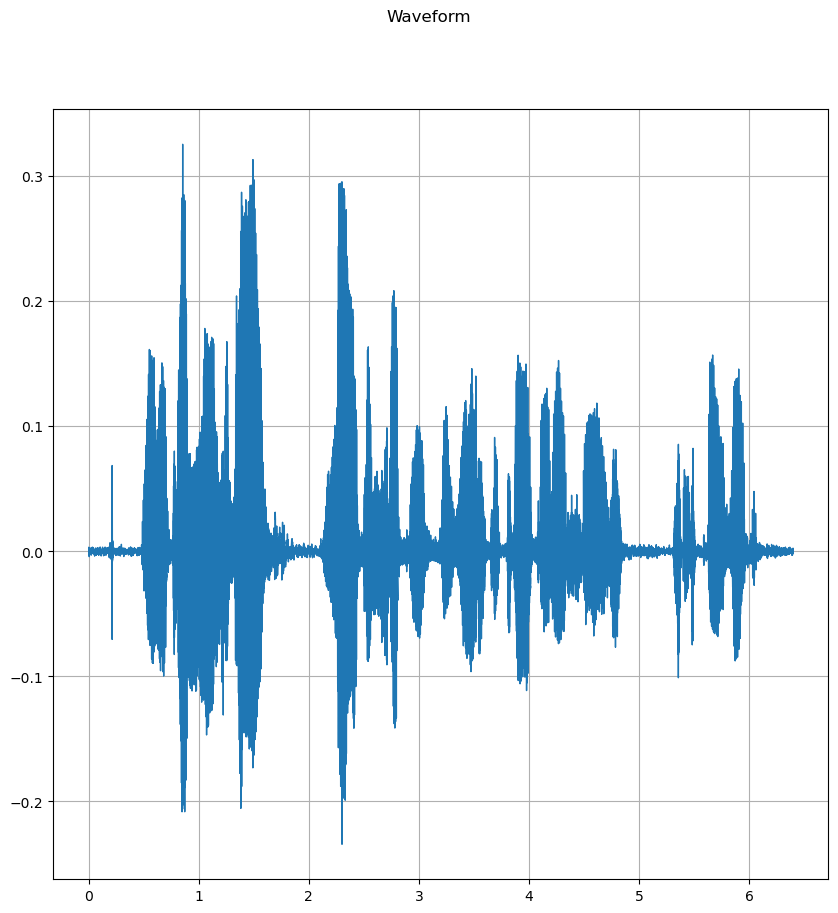

In [ ]:
plot_waveform(wav.squeeze(0), new_sr)

In [ ]:
ipd.Audio(wav.squeeze(0).numpy(), rate=new_sr)

In [ ]:
# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]


1 torch.Size([1, 8, 480])


In [ ]:
print(encoded_frames[0][0].shape)
print(codes.shape)

torch.Size([1, 8, 480])
torch.Size([1, 8, 480])


<matplotlib.image.AxesImage>

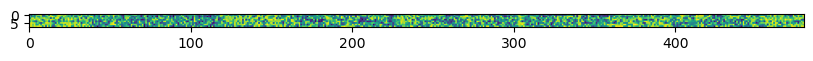

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(codes.squeeze().numpy())

In [ ]:
decoded = model.decode(encoded_frames=encoded_frames)
decoded.shape

torch.Size([1, 1, 153600])

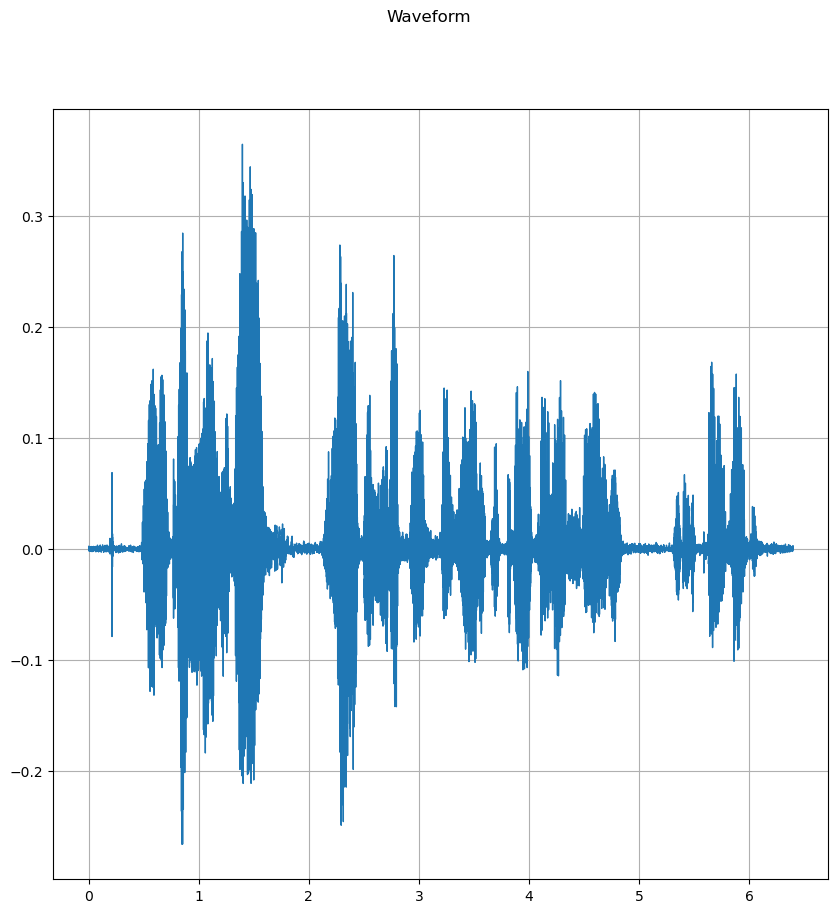

In [ ]:
plot_waveform(decoded.detach().squeeze(0), new_sr)

In [ ]:
ipd.Audio(decoded.detach().squeeze(0).numpy(), rate=new_sr)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()